In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('fivethirtyeight')

## Load Protected Silver Recipe

In [2]:
# Load the data Nasrat sent to us
pth = "C:/Users/ashcraft/Desktop/refractivedata/parsed_indices_from_nasrat.xlsx"
index_frame = pd.read_excel(pth)

wl_Ag = index_frame['Wavelength-Ag']
n_Ag = index_frame['Refractive Index=Ag']
k_Ag = index_frame['Extinction Coefficient-Ag']

wl_ZnS = index_frame['Wavelength-ZnS']
n_ZnS = index_frame['Refractive Index-ZnS']
k_ZnS = index_frame['Extinction Coefficient-ZnS']

wl_Al2O3 = index_frame['Wavelength-Al2O3']
n_Al2O3 = index_frame['Refractive Index-Al2O3']
k_Al2O3 = index_frame['Extinction Coefficient-Al2O3']

wl_BK7 = index_frame['Wavelength-BK7']
n_BK7 = index_frame['Refractive Index-BK7']

## Create Cubic Interpolation of Refractive Index Data

In [3]:
# Create some interpolators to construct the data
from scipy.interpolate import interp1d

# grab the data on the range from 405-1400nm
wl_Ag_parsed = wl_Ag[61:83]
n_Ag_parsed = n_Ag[61:83]
k_Ag_parsed = k_Ag[61:83]

wl_ZnS_parsed = wl_ZnS[:37]
n_ZnS_parsed = n_ZnS[:37]
k_ZnS_parsed = k_ZnS[:37]

wl_Al2O3_parsed = wl_Al2O3[21:61]
n_Al2O3_parsed = n_Al2O3[21:61]
k_Al2O3_parsed = k_Al2O3[21:61]

wl_BK7_parsed = wl_BK7[64:292]
n_BK7_parsed = n_BK7[64:292]

# The interpolated data
f_n_Ag = interp1d(wl_Ag_parsed, n_Ag_parsed, 'cubic')
f_k_Ag = interp1d(wl_Ag_parsed, k_Ag_parsed, 'cubic')

f_n_ZnS = interp1d(wl_ZnS_parsed, n_ZnS_parsed, 'cubic')
f_k_ZnS = interp1d(wl_ZnS_parsed, k_ZnS_parsed, 'cubic')

f_n_Al2O3 = interp1d(wl_Al2O3_parsed, n_Al2O3_parsed, 'cubic')
f_k_Al2O3 = interp1d(wl_Al2O3_parsed, k_Al2O3_parsed, 'cubic')

f_n_BK7 = interp1d(wl_BK7_parsed, n_BK7_parsed, 'cubic')

f_Ag = lambda wvl: f_n_Ag(wvl) + 1j*f_k_Ag(wvl)
f_ZnS = lambda wvl: f_n_ZnS(wvl) + 1j*f_k_ZnS(wvl)
f_Al2O3 = lambda wvl: f_n_Al2O3(wvl) + 1j*f_k_Al2O3(wvl)
f_BK7 = f_n_BK7

## Configure the Poke Rayfront

In [4]:
# Start off with some poke installations
from poke.writing import read_serial_to_rayfront
import poke.plotting as plot

In [5]:
pth_to_elt = 'C:/Users/ashcraft/Desktop/poke/tests/ELT_rayfront_aspolarized_64rays_0.6um.msgpack'
rayfront = read_serial_to_rayfront(pth_to_elt)

In [6]:
# compute the jones pupil, aloc = +y for the ELT
# we started out with an all-aluminum model
rayfront.compute_jones_pupil(aloc=np.array([0.,1.,0.]))

## Plot the Jones Pupil

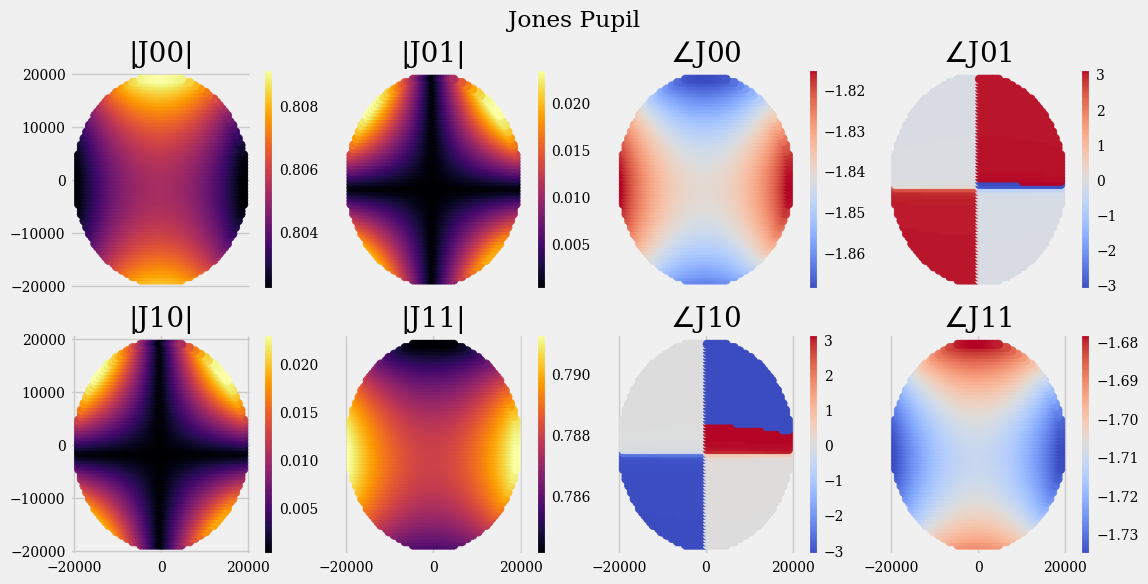

In [7]:
plot.jones_pupil(rayfront)

## Now use the Protected Silver Coating
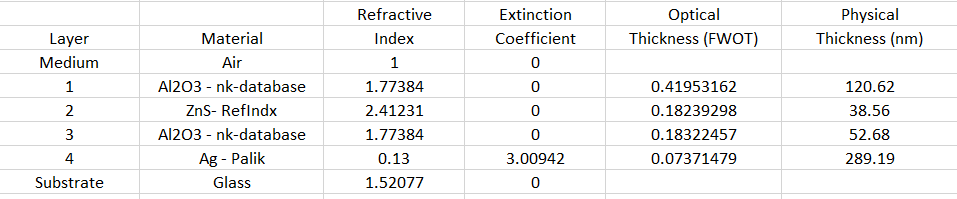

In [8]:
# Let's print what the surfaces were before
display('Old surflist','-'*10,rayfront.surfaces)
wvl = 632.8
protected_Ag = [
    (f_Al2O3(wvl),120.62e-9),
    (f_ZnS(wvl),38.56e-9),
    (f_Al2O3(wvl),52.68e-9),
    (f_Ag(wvl),289.19e-9),
    (f_BK7(wvl)) # ignores physical thickness, this is the substrate

]

# Set up the new surfaces
s1 = {
    'surf':1,
    'coating':protected_Ag,
    'mode':'reflect'
}
s3 = {
    'surf':3,
    'coating':protected_Ag,
    'mode':'reflect'
}
s5 = {
    'surf':5,
    'coating':protected_Ag,
    'mode':'reflect'
}
s8 = {
    'surf':8,
    'coating':protected_Ag,
    'mode':'reflect'
}
s12 = {
    'surf':12,
    'coating':protected_Ag,
    'mode':'reflect'
}

# update the surflist
rayfront.surfaces = [s1,s3,s5,s8,s12]
# display('New surflist','-'*10,rayfront.surfaces) # verbose so it's commented out now

'Old surflist'

'----------'

[{'surf': 1, 'coating': (1.2+7.115j), 'mode': 'reflect'},
 {'surf': 3, 'coating': (1.2+7.115j), 'mode': 'reflect'},
 {'surf': 5, 'coating': (1.2+7.115j), 'mode': 'reflect'},
 {'surf': 8, 'coating': (1.2+7.115j), 'mode': 'reflect'},
 {'surf': 12, 'coating': (1.2+7.115j), 'mode': 'reflect'}]

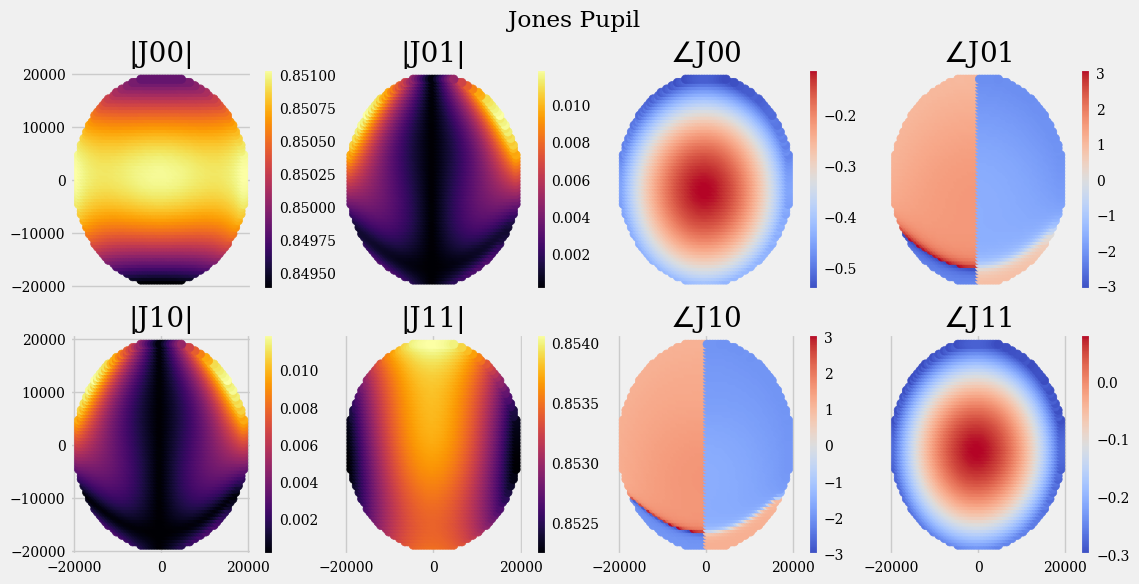

In [9]:
# compute and plot the new jones pupil
rayfront.compute_jones_pupil(exit_x=np.array([1.,0.,0.]),aloc=np.array([0.,1.,0.]))
plot.jones_pupil(rayfront)

In [10]:
def get_reflectivity(jones):

    from poke.poke_math import eigenvalues_2x2

    e1,e2 = eigenvalues_2x2(jones)

    Rs = np.abs(e1)**2
    Rp = np.abs(e2)**2

    return Rs,Rp

def get_average_reflectivity(jones):

    from poke.poke_math import eigenvalues_2x2

    e1,e2 = eigenvalues_2x2(jones)

    Rs = np.abs(e1)**2
    Rp = np.abs(e2)**2

    return (Rs+Rp)/2

def get_retardance(jones):

    from poke.poke_math import eigenvalues_2x2
    
    e1,e2 = eigenvalues_2x2(jones)

    R = np.angle(e1)-np.angle(e2)
    return R

def get_diattenuation(jones):

    from poke.poke_math import eigenvalues_2x2
    
    e1,e2 = eigenvalues_2x2(jones)

    D = (np.abs(e1)**2-np.abs(e2)**2) / (np.abs(e1)**2+np.abs(e2)**2)
    return D

Rs,Rp = get_reflectivity(rayfront.jones_pupil[-1]) 

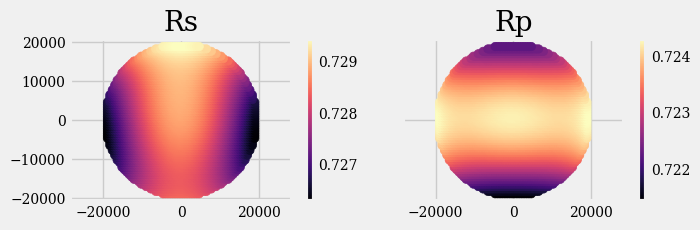

In [11]:
plt.figure(figsize=[7,2])
plt.subplot(121)
plt.title('Rs')
plt.scatter(rayfront.xData[0,0],rayfront.yData[0,0],c=Rs)
plt.colorbar()
plt.axis('equal')
plt.subplot(122)
plt.title('Rp')
plt.scatter(rayfront.xData[0,0],rayfront.yData[0,0],c=Rp)
plt.colorbar()
plt.yticks([0],'')
plt.axis('equal')
plt.show()

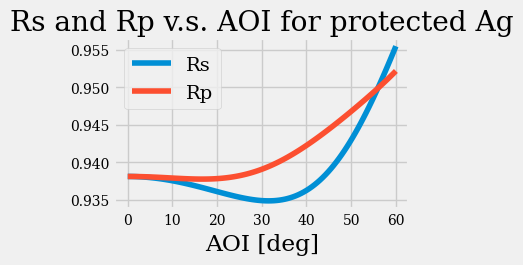

In [12]:
# Compare with expected thin film performance
from poke.thinfilms import compute_thin_films_broadcasted

aoi = np.linspace(0,np.radians(60),100)
rs,ts = compute_thin_films_broadcasted(protected_Ag,aoi,600e-9,substrate_index=protected_Ag[-1],polarization='s')
rp,tp = compute_thin_films_broadcasted(protected_Ag,aoi,600e-9,substrate_index=protected_Ag[-1],polarization='p')

plt.style.use('fivethirtyeight')
plt.figure()
plt.title('Rs and Rp v.s. AOI for protected Ag')
plt.plot(np.degrees(aoi),np.abs(rs)**2,label='Rs')
plt.plot(np.degrees(aoi),np.abs(rp)**2,label='Rp')
plt.xlabel('AOI [deg]')
plt.legend()
plt.show()

wavelength =  632.8 nm


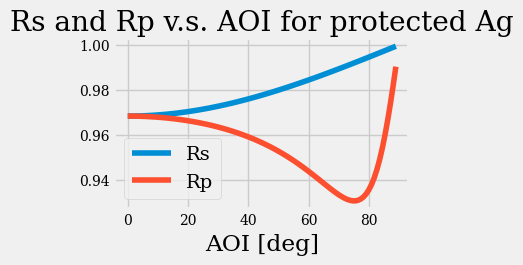

In [13]:
# Does it happen with just silver on bk7?
print('wavelength = ',wvl,'nm')
test_coating = [(f_Ag(wvl),289e-9),(f_BK7(wvl))]
aoi = np.linspace(0,np.radians(89),100)
rs,ts = compute_thin_films_broadcasted(test_coating,aoi,600e-9,substrate_index=test_coating[-1],polarization='s')
rp,tp = compute_thin_films_broadcasted(test_coating,aoi,600e-9,substrate_index=test_coating[-1],polarization='p')

plt.style.use('fivethirtyeight')
plt.figure()
plt.title('Rs and Rp v.s. AOI for protected Ag')
plt.plot(np.degrees(aoi),np.abs(rs)**2,label='Rs')
plt.plot(np.degrees(aoi),np.abs(rp)**2,label='Rp')
plt.xlabel('AOI [deg]')
plt.legend()
plt.show()

# RefractiveIndex.info for comparison
This is for just silver, no bk7 substrate
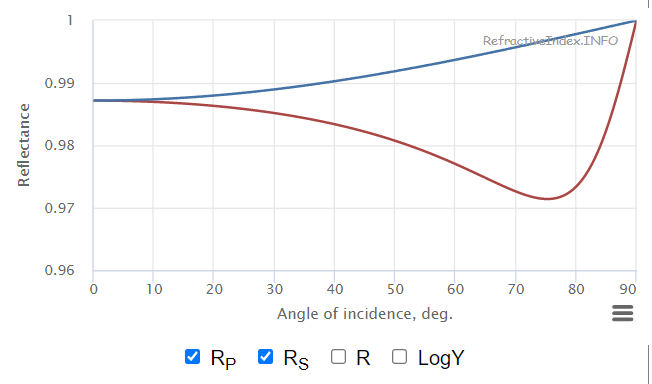

## Let's try optimizing the distance of the thin films
This is essentially a piston mode. We will make the figure of merit some function of the Reflectivity and Retardance

$$ C = (\sum_{i=0}^{N} (1-R_{i})^{2}) + Var(R)$$

In [26]:
# Vary the thicknesses of the dielectric layers
nsurf = len(rayfront.surfaces)-2 # subtract surfaces we don't want
ncoat = 3
a = np.empty([ncoat,nsurf]) # our coefficient vector for optimization
a[0],a[1],a[2] = 120.62e-9,38.56e-9,52.68e-9
print(a)

[[1.2062e-07 1.2062e-07 1.2062e-07]
 [3.8560e-08 3.8560e-08 3.8560e-08]
 [5.2680e-08 5.2680e-08 5.2680e-08]]


In [38]:
# set up the cost function
def minimize_retardance(a,ncoat,nsurf,return_jones=False):

    a = a.reshape([ncoat,nsurf])
    wvl = 632.8
    surfnums = [1,3,5,8,12]
    surflist = []

    for i,surf in enumerate(surfnums):

        if (i+1) > nsurf:

            # print(f'not optimizing mirror {surf}')

            protected_Ag_update = protected_Ag

            # Set up the new surfaces
            sN = {
                'surf':surf,
                'coating':protected_Ag_update,
                'mode':'reflect'
            }

            surflist.append(sN)

        else:
            # print(f'optimizing mirror {surf}')
            protected_Ag_update = [
                (f_Al2O3(wvl),a[0,i]),
                (f_ZnS(wvl),a[1,i]),
                (f_Al2O3(wvl),a[2,i]),
                (f_Ag(wvl),289.19e-9),
                (f_BK7(wvl)) # ignores physical thickness, this is the substrate
            ]

            # Set up the new surfaces
            sN = {
                'surf':surf,
                'coating':protected_Ag_update,
                'mode':'reflect'
            }

            surflist.append(sN)

    rayfront.surfaces = surflist
    rayfront.compute_jones_pupil(aloc=np.array([0.,1.,0.]))
    jones = rayfront.jones_pupil[-1][...,:2,:2]
    retardance = get_retardance(jones)
    reflectivity = get_average_reflectivity(jones)
    thickness_constraint = (np.min(a) < 5e-9).astype(int)
    retardance_constraint = np.sum(retardance**2)/retardance.size
    reflectivity_constraint = np.sum(1-reflectivity)**2/reflectivity.size
    cost = retardance_constraint + reflectivity_constraint + thickness_constraint*100

    if return_jones:
        return jones
    else:
        return cost
    

In [39]:
from scipy.optimize import minimize
# print(minimize_retardance(a,ncoat,nsurf))

x = minimize(minimize_retardance,a.ravel(),args=(ncoat,nsurf),method='Nelder-Mead',options={'maxiter':5000})

In [40]:
print(x)
jones_after = minimize_retardance(x.x,ncoat,nsurf,return_jones=True)

 final_simplex: (array([[1.78464156e-07, 1.19113994e-08, 1.87372526e-07, 7.26369463e-08,
        6.06273645e-08, 6.17739379e-08, 4.94416923e-08, 6.77809514e-08,
        5.84401859e-08],
       [1.78396856e-07, 1.20035765e-08, 1.87324297e-07, 7.27036457e-08,
        6.06071545e-08, 6.17266966e-08, 4.94655710e-08, 6.78049198e-08,
        5.84469814e-08],
       [1.78321182e-07, 1.20509556e-08, 1.87321162e-07, 7.26993691e-08,
        6.05648497e-08, 6.18213889e-08, 4.94730426e-08, 6.77987892e-08,
        5.84075221e-08],
       [1.78355529e-07, 1.19456384e-08, 1.87457852e-07, 7.26813026e-08,
        6.06002344e-08, 6.16687935e-08, 4.95465456e-08, 6.78339273e-08,
        5.84231879e-08],
       [1.78390295e-07, 1.20396512e-08, 1.87313649e-07, 7.26776516e-08,
        6.05879599e-08, 6.17609015e-08, 4.94256807e-08, 6.77759297e-08,
        5.84967096e-08],
       [1.78299063e-07, 1.17975593e-08, 1.87418524e-07, 7.27790101e-08,
        6.06297760e-08, 6.17427585e-08, 4.94982161e-08, 6.78873736

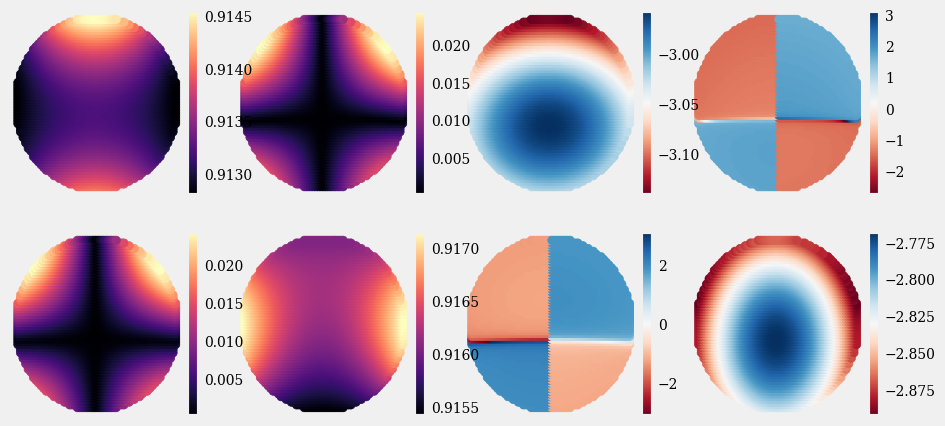

In [41]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
xd,yd = rayfront.xData[0,0],rayfront.yData[0,0]
op1 = np.abs
op2 = np.angle

# plot a jones pupil
jlist = [jones_after[...,0,0],jones_after[...,0,1],jones_after[...,1,0],jones_after[...,1,1]]
fig,ax = plt.subplots(ncols=4,nrows=2,figsize=[10,5])
ax_amp = ax[0:2,0:2].ravel()
ax_phs = ax[0:2,2:4].ravel()

for data,axa,axp in zip(jlist,ax_amp,ax_phs):

    ima = axa.scatter(xd,yd,c=op1(data))
    axa_div = make_axes_locatable(axa)
    caxa = axa_div.append_axes("right", size="7%", pad="2%")
    cba = fig.colorbar(ima, cax=caxa)
    axa.get_xaxis().set_visible(False)
    axa.get_yaxis().set_visible(False)

    imp = axp.scatter(xd,yd,c=op2(data),cmap='RdBu')
    axp_div = make_axes_locatable(axp)
    caxp = axp_div.append_axes("right", size="7%", pad="2%")
    cbp = fig.colorbar(imp, cax=caxp)
    axp.get_xaxis().set_visible(False)
    axp.get_yaxis().set_visible(False)

plt.show()

Retardance Variance =  0.0005019728942429877
Diattenuation Variance =  1.2884378938499544e-05


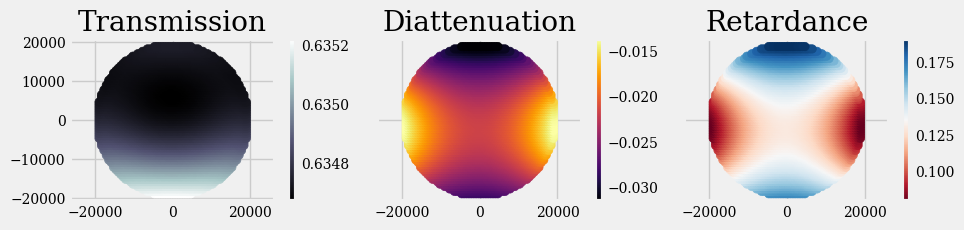

Retardance Variance =  0.0006534769928048568
Diattenuation Variance =  4.771300814766311e-07


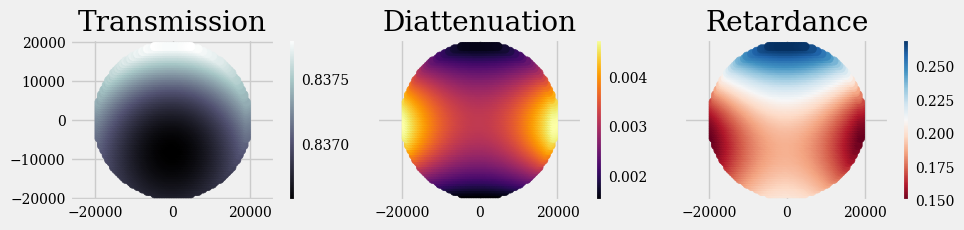

In [42]:
Ravg = get_average_reflectivity(rayfront.jones_pupil[0])
Ret = get_retardance(rayfront.jones_pupil[0])
Det = get_diattenuation(rayfront.jones_pupil[0])
print('Retardance Variance = ',np.var(Ret))
print('Diattenuation Variance = ',np.var(Det))

plt.figure(figsize=[10,2])
plt.subplot(131)
plt.title('Transmission')
plt.scatter(xd,yd,c=Ravg,cmap='bone')
plt.colorbar()
plt.axis('equal')
plt.subplot(132)
plt.title('Diattenuation')
plt.scatter(xd,yd,c=Det,cmap='inferno')
plt.colorbar()
plt.yticks([0],'')
plt.axis('equal')
plt.subplot(133)
plt.title('Retardance')
plt.scatter(xd,yd,c=Ret,cmap='RdBu')
plt.colorbar()
plt.yticks([0],'')
plt.axis('equal')
plt.show()

Ravg = get_average_reflectivity(jones_after)
Ret = get_retardance(jones_after)
Det = get_diattenuation(jones_after)
print('Retardance Variance = ',np.var(Ret))
print('Diattenuation Variance = ',np.var(Det))
plt.figure(figsize=[10,2])
plt.subplot(131)
plt.title('Transmission')
plt.scatter(xd,yd,c=Ravg,cmap='bone')
plt.colorbar()
plt.axis('equal')
plt.subplot(132)
plt.title('Diattenuation')
plt.scatter(xd,yd,c=Det,cmap='inferno')
plt.colorbar()
plt.yticks([0],'')
plt.axis('equal')
plt.subplot(133)
plt.title('Retardance')
plt.scatter(xd,yd,c=Ret,cmap='RdBu')
plt.colorbar()
plt.yticks([0],'')
plt.axis('equal')
plt.show()

In [71]:
for surf in rayfront.surfaces:
    display(surf)

{'surf': 1,
 'coating': [((1.7662145185033484+0j), 1.2062e-07),
  ((2.350487605487942+0j), 3.856e-08),
  ((1.7662145185033484+0j), 5.268e-08),
  ((0.13557358527963842+3.984106320720322j), 2.8919e-07),
  array(1.51508851)],
 'mode': 'reflect'}

{'surf': 3,
 'coating': [((1.7662145185033484+0j), 1.587249220722457e-07),
  ((2.350487605487942+0j), 7.481650630319082e-08),
  ((1.7662145185033484+0j), 5.33913404046365e-08),
  ((0.13557358527963842+3.984106320720322j), 2.8919e-07),
  array(1.51508851)],
 'mode': 'reflect'}

{'surf': 5,
 'coating': [((1.7662145185033484+0j), 5.0010964743925055e-09),
  ((2.350487605487942+0j), 6.488602517246179e-08),
  ((1.7662145185033484+0j), 5.636235418830932e-08),
  ((0.13557358527963842+3.984106320720322j), 2.8919e-07),
  array(1.51508851)],
 'mode': 'reflect'}

{'surf': 8,
 'coating': [((1.7662145185033484+0j), 1.587249220722457e-07),
  ((2.350487605487942+0j), 7.481650630319082e-08),
  ((1.7662145185033484+0j), 5.33913404046365e-08),
  ((0.13557358527963842+3.984106320720322j), 2.8919e-07),
  array(1.51508851)],
 'mode': 'reflect'}

{'surf': 12,
 'coating': [((1.7662145185033484+0j), 5.0010964743925055e-09),
  ((2.350487605487942+0j), 6.488602517246179e-08),
  ((1.7662145185033484+0j), 5.636235418830932e-08),
  ((0.13557358527963842+3.984106320720322j), 2.8919e-07),
  array(1.51508851)],
 'mode': 'reflect'}

## Monte Carlo Trial for Coating layer sensitivity

16 µs ± 81.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


0.00015999999999999999